In [1]:
# https://www.kaggle.com/bethsung/bengali-graphemes-starter-eda-multi-output-cnn/edit

In [2]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple


In [3]:
!pip install keras 

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm.auto import tqdm
from glob import glob
import time, gc
import cv2

from tensorflow import keras
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
from matplotlib import pyplot as plt
import seaborn as sns


In [5]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('home/beth/Galvanize/capstone/captstone_2_proposal/data/bengaliai-cv19'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [6]:
!ls

 3_29_2021_dry_run_1.ipynb			    class_map_corrected.csv
 3_29_2021_dry_run.ipynb			    kalpurush-2.ttf
 3_30_2021_dry_run.ipynb			    logs
 3_31_2021_dry_run-more_layers_n_pools.ipynb	    sample_submission.csv
 3_31_2021_dry_run_with_layer_learning_rate.ipynb   test.csv
 3_31_2021_resnet50.ipynb			    train.csv
'3_31_night_thanks_to_Kaushal Shah.ipynb'


In [7]:
train_df_ = pd.read_csv('train.csv')
test_df_ = pd.read_csv('test.csv')
class_map_df = pd.read_csv('class_map_corrected.csv')
sample_sub_df = pd.read_csv('sample_submission.csv')

In [8]:
train_df_.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [9]:
test_df_.head()

,row_id,image_id,component
0,Test_0_consonant_diacritic,Test_0,consonant_diacritic
1,Test_0_grapheme_root,Test_0,grapheme_root
2,Test_0_vowel_diacritic,Test_0,vowel_diacritic
3,Test_1_consonant_diacritic,Test_1,consonant_diacritic
4,Test_1_grapheme_root,Test_1,grapheme_root


In [10]:
class_map_df.head()

,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই


In [11]:
sample_sub_df.head()

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,0
2,Test_0_vowel_diacritic,0
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,0


In [12]:
print(f'Size of training data: {train_df_.shape}')
print(f'Size of test data: {test_df_.shape}')
print(f'Size of class map: {class_map_df.shape}')

Size of training data: (200840, 5)
Size of test data: (36, 3)
Size of class map: (187, 3)


# Exploratory Data Analysis

In [13]:
HEIGHT = 236
WIDTH = 236

def get_n(df, field, n, top=True):
    top_graphemes = df.groupby([field]).size().reset_index(name='counts')['counts'].sort_values(ascending=not top)[:n]
    top_grapheme_roots = top_graphemes.index
    top_grapheme_counts = top_graphemes.values
    top_graphemes = class_map_df[class_map_df['component_type'] == field].reset_index().iloc[top_grapheme_roots]
    top_graphemes.drop(['component_type', 'label'], axis=1, inplace=True)
    top_graphemes.loc[:, 'count'] = top_grapheme_counts
    return top_graphemes

def image_from_char(char):
    image = Image.new('RGB', (WIDTH, HEIGHT))
    draw = ImageDraw.Draw(image)
    myfont = ImageFont.truetype('kalpurush-2.ttf', 120)
    w, h = draw.textsize(char, font=myfont)
    draw.text(((WIDTH - w) / 2,(HEIGHT - h) / 3), char, font=myfont)

    return image

In [14]:
print(f'Number of unique grapheme roots: {train_df_["grapheme_root"].nunique()}')
print(f'Number of unique vowel diacritic: {train_df_["vowel_diacritic"].nunique()}')
print(f'Number of unique consonant diacritic: {train_df_["consonant_diacritic"].nunique()}')

Number of unique grapheme roots: 168
Number of unique vowel diacritic: 11
Number of unique consonant diacritic: 7


# Most used top 10 Grapheme Roots in training set

In [15]:
top_10_roots = get_n(train_df_, 'grapheme_root', 10)
top_10_roots

,index,component,count
72,72,দ,5736
64,64,ত,5596
13,13,ক,5420
107,107,ব,5321
23,23,গ,5149
96,96,প,4926
113,113,ভ,4395
147,147,স,4392
133,133,শ,4374
115,115,ম,4015


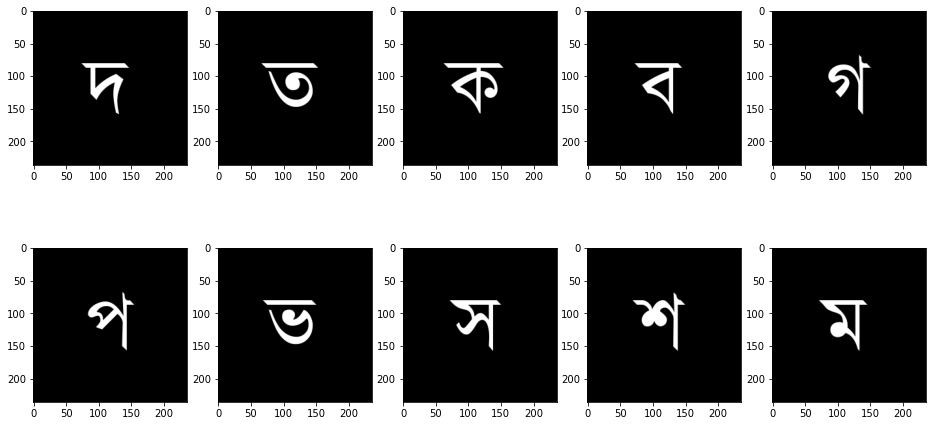

In [16]:
f, ax = plt.subplots(2, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(10):
    ax[i].imshow(image_from_char(top_10_roots['component'].iloc[i]), cmap='Greys')

# Least used 10 Grapheme Roots in training set

In [17]:
bottom_10_roots = get_n(train_df_, 'grapheme_root', 10, False)
bottom_10_roots

,index,component,count
73,73,দ্ঘ,130
33,33,ঙ্ক্ত,136
102,102,প্স,141
158,158,স্স,143
45,45,জ্জ্ব,144
130,130,ল্ব,144
1,1,ঃ,145
12,12,ঔ,146
0,0,ং,147
63,63,ণ্ণ,149


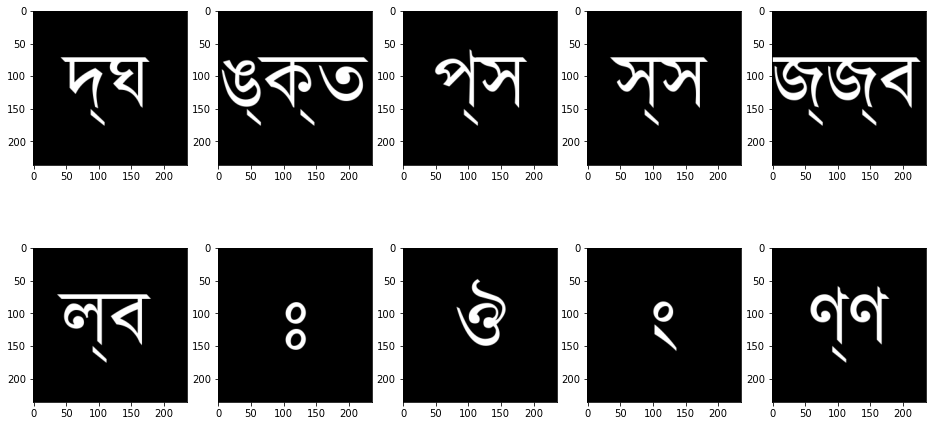

In [18]:
f, ax = plt.subplots(2, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(10):
    ax[i].imshow(image_from_char(bottom_10_roots['component'].iloc[i]), cmap='Greys')

# Top 5 Vowel Diacritic in taining data

In [19]:
top_5_vowels = get_n(train_df_, 'vowel_diacritic', 5)
top_5_vowels

,index,component,count
0,168,0,41508
1,169,া,36886
7,175,ে,28723
2,170,ি,25967
4,172,ু,18848


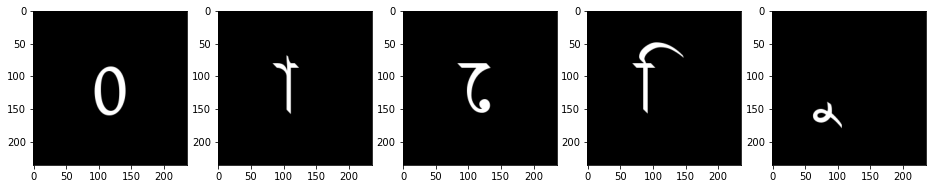

In [20]:
f, ax = plt.subplots(1, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(5):
    ax[i].imshow(image_from_char(top_5_vowels['component'].iloc[i]), cmap='Greys')

# Top 5 Consonant Diacritic in training data

In [21]:
top_5_consonants = get_n(train_df_, 'consonant_diacritic', 5)
top_5_consonants

,index,component,count
0,179,0,125278
2,181,র্,23465
5,184,্র,21397
4,183,্য,21270
1,180,ঁ,7424


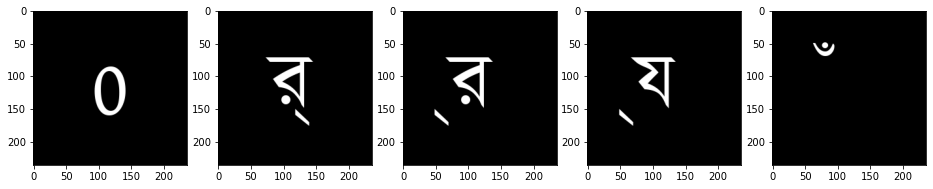

In [22]:
f, ax = plt.subplots(1, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(5):
    ax[i].imshow(image_from_char(top_5_consonants['component'].iloc[i]), cmap='Greys')

In [23]:
train_df_ = train_df_.drop(['grapheme'], axis=1, inplace=False)

In [24]:
train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']] = train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].astype('uint8')

In [25]:
IMG_SIZE=64
N_CHANNELS=1

In [26]:
def resize(df, size=64, need_progress_bar=True):
    resized = {}
    resize_size=64
    if need_progress_bar:
        for i in tqdm(range(df.shape[0])): # progress 
            image=df.loc[df.index[i]].values.reshape(137,236)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    else:
        for i in range(df.shape[0]):
            #image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size),None,fx=0.5,fy=0.5,interpolation=cv2.INTER_AREA)
            image=df.loc[df.index[i]].values.reshape(137,236)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    resized = pd.DataFrame(resized).T
    return resized

In [27]:
def get_dummies(df):
    cols = []
    for col in df:
        cols.append(pd.get_dummies(df[col].astype(str)))
    return pd.concat(cols, axis=1)

# Basic Model

In [28]:
inputs = Input(shape = (IMG_SIZE, IMG_SIZE, 1))

model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Flatten()(model)
model = Dense(1024, activation = "relu")(model)
model = Dropout(rate=0.3)(model)
dense = Dense(512, activation = "relu")(model)

head_root = Dense(168, activation = 'softmax')(dense)
head_vowel = Dense(11, activation = 'softmax')(dense)
head_consonant = Dense(7, activation = 'softmax')(dense)

model = Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   9248        conv2d_1[0][0]                   
______________________________________________________________________________________________

# Let's visualize the 3-tailed (3 output) CNN by plotting it.

In [30]:
!pip install pydot

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple


In [31]:
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple


In [32]:
!pip install pydotplus

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple


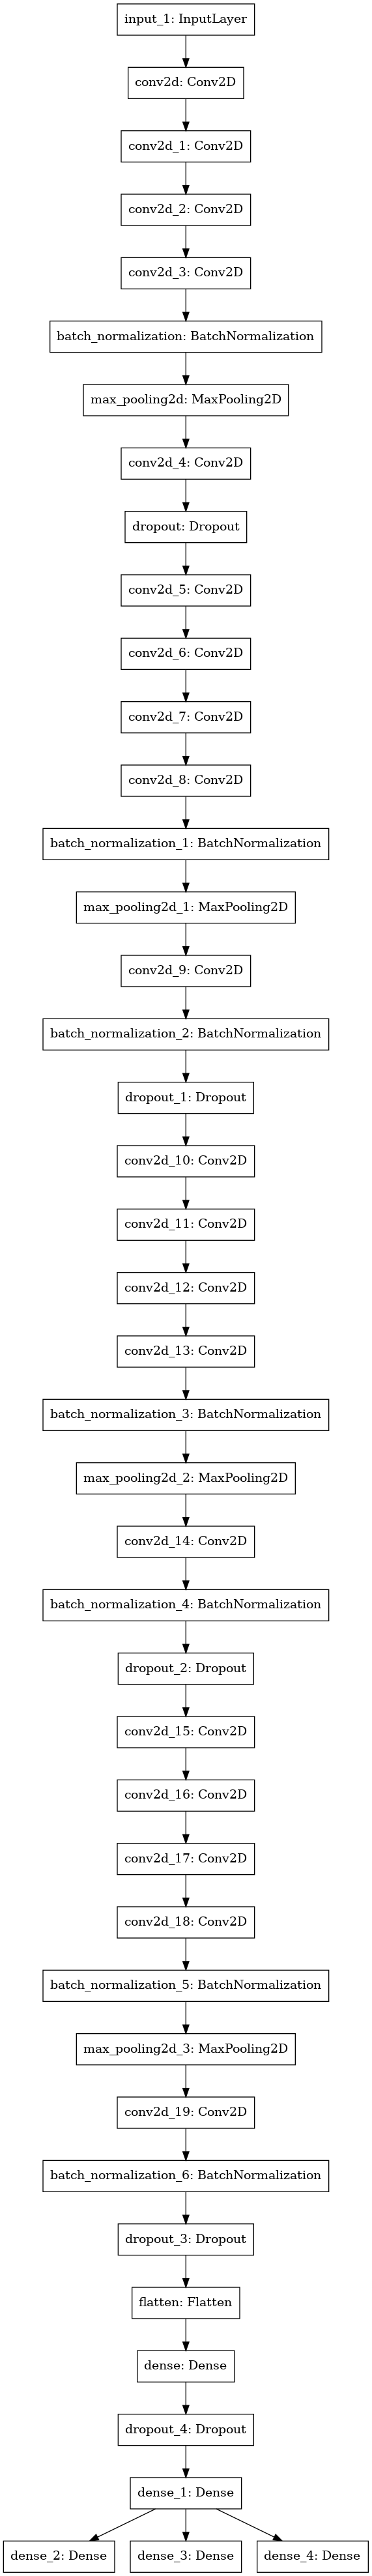

In [33]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png')

In [34]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
# Set a learning rate annealer. Learning rate will be half after 3 epochs if accuracy is not increased

learning_rate_reduction_root = ReduceLROnPlateau(monitor='dense_3_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_vowel = ReduceLROnPlateau(monitor='dense_4_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_consonant = ReduceLROnPlateau(monitor='dense_5_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)


In [36]:
batch_size = 256
epochs = 30

In [37]:
class MultiOutputDataGenerator(keras.preprocessing.image.ImageDataGenerator):

    def flow(self,
             x,
             y=None,
             batch_size=32,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):

        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)


        for flowx, flowy in super().flow(x, targets, batch_size=batch_size,
                                         shuffle=shuffle):
            target_dict = {}
            i = 0
            for output in ordered_outputs:
                target_length = target_lengths[output]
                target_dict[output] = flowy[:, i: i + target_length]
                i += target_length

            yield flowx, target_dict

In [38]:
HEIGHT = 137
WIDTH = 236

# Training loop

In [3]:
import pandas as pd

In [ ]:
histories = []
for i in range(4):
    train_df = pd.merge(pd.read_parquet(f'/home/beth/Galvanize/capstone/capstone_2_proposal/data/bengaliai-cv19/train_image_data_{i}.parquet'), train_df_, on='image_id').drop(['image_id'], axis=1)
    
    # Visualize few samples of current training dataset
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))
    count=0
    for row in ax:
        for col in row:
            col.imshow(resize(train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1).iloc[[count]], need_progress_bar=False).values.reshape(-1).reshape(IMG_SIZE, IMG_SIZE).astype(np.float64))
            count += 1
    plt.show()
    
    X_train = train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1)
    X_train = resize(X_train)/255
    
    # CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
    X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    Y_train_root = pd.get_dummies(train_df['grapheme_root']).values
    Y_train_vowel = pd.get_dummies(train_df['vowel_diacritic']).values
    Y_train_consonant = pd.get_dummies(train_df['consonant_diacritic']).values

    print(f'Training images: {X_train.shape}')
    print(f'Training labels root: {Y_train_root.shape}')
    print(f'Training labels vowel: {Y_train_vowel.shape}')
    print(f'Training labels consonants: {Y_train_consonant.shape}')

    # Divide the data into training and validation set
    x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant = train_test_split(X_train, Y_train_root, Y_train_vowel, Y_train_consonant, test_size=0.08, random_state=666)
    del train_df
    del X_train
    del Y_train_root, Y_train_vowel, Y_train_consonant

    # Data augmentation for creating more training data
    datagen = MultiOutputDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


    # This will just calculate parameters required to augment the given data. This won't perform any augmentations
    datagen.fit(x_train)

    # Fit the model
    history = model.fit_generator(datagen.flow(x_train, {'dense_3': y_train_root, 'dense_4': y_train_vowel, 'dense_5': y_train_consonant}, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant]), 
                              steps_per_epoch=x_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction_root, learning_rate_reduction_vowel, learning_rate_reduction_consonant])

    histories.append(history)
    
    # Delete to reduce memory usage
    del x_train
    del x_test
    del y_train_root
    del y_test_root
    del y_train_vowel
    del y_test_vowel
    del y_train_consonant
    del y_test_consonant
    gc.collect()

In [1]:
%matplotlib inline
def plot_loss(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['loss'], label='train_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_3_loss'], label='train_root_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_4_loss'], label='train_vowel_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_5_loss'], label='train_consonant_loss')
    
    plt.plot(np.arange(0, epoch), his.history['val_dense_3_loss'], label='val_train_root_loss')
    plt.plot(np.arange(0, epoch), his.history['val_dense_4_loss'], label='val_train_vowel_loss')
    plt.plot(np.arange(0, epoch), his.history['val_dense_5_loss'], label='val_train_consonant_loss')
    
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

def plot_acc(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['dense_3_accuracy'], label='train_root_acc')
    plt.plot(np.arange(0, epoch), his.history['dense_4_accuracy'], label='train_vowel_accuracy')
    plt.plot(np.arange(0, epoch), his.history['dense_5_accuracy'], label='train_consonant_accuracy')
    
    plt.plot(np.arange(0, epoch), his.history['val_dense_3_accuracy'], label='val_root_acc')
    plt.plot(np.arange(0, epoch), his.history['val_dense_4_accuracy'], label='val_vowel_accuracy')
    plt.plot(np.arange(0, epoch), his.history['val_dense_5_accuracy'], label='val_consonant_accuracy')
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.show()

In [ ]:
for dataset in range(4):
    plot_loss(histories[dataset], epochs, f'Training Dataset: {dataset}')
    plot_acc(histories[dataset], epochs, f'Training Dataset: {dataset}')

In [ ]:
del histories
gc.collect()

In [ ]:
preds_dict = {
    'grapheme_root': [],
    'vowel_diacritic': [],
    'consonant_diacritic': []
}

In [ ]:
components = ['consonant_diacritic', 'grapheme_root', 'vowel_diacritic']
target=[] # model predictions placeholder
row_id=[] # row_id place holder
for i in range(4):
    df_test_img = pd.read_parquet('/kaggle/input/bengaliai-cv19/test_image_data_{}.parquet'.format(i)) 
    df_test_img.set_index('image_id', inplace=True)

    X_test = resize(df_test_img, need_progress_bar=False)/255
    X_test = X_test.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    preds = model.predict(X_test)

    for i, p in enumerate(preds_dict):
        preds_dict[p] = np.argmax(preds[i], axis=1)

    for k,id in enumerate(df_test_img.index.values):  
        for i,comp in enumerate(components):
            id_sample=id+'_'+comp
            row_id.append(id_sample)
            target.append(preds_dict[comp][k])
    del df_test_img
    del X_test
    gc.collect()

df_sample = pd.DataFrame(
    {
        'row_id': row_id,
        'target':target
    },
    columns = ['row_id','target'] 
)
df_sample.to_csv('submission.csv',index=False)
df_sample.head()

In [6]:
df_index=pd.read_csv('train.csv')
df_index

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো
...,...,...,...,...,...
200835,Train_200835,22,7,2,র্খে
200836,Train_200836,65,9,0,ত্তো
200837,Train_200837,2,1,4,অ্যা
200838,Train_200838,152,9,0,স্নো


In [7]:
df_index.shape

(200840, 5)

<AxesSubplot:>

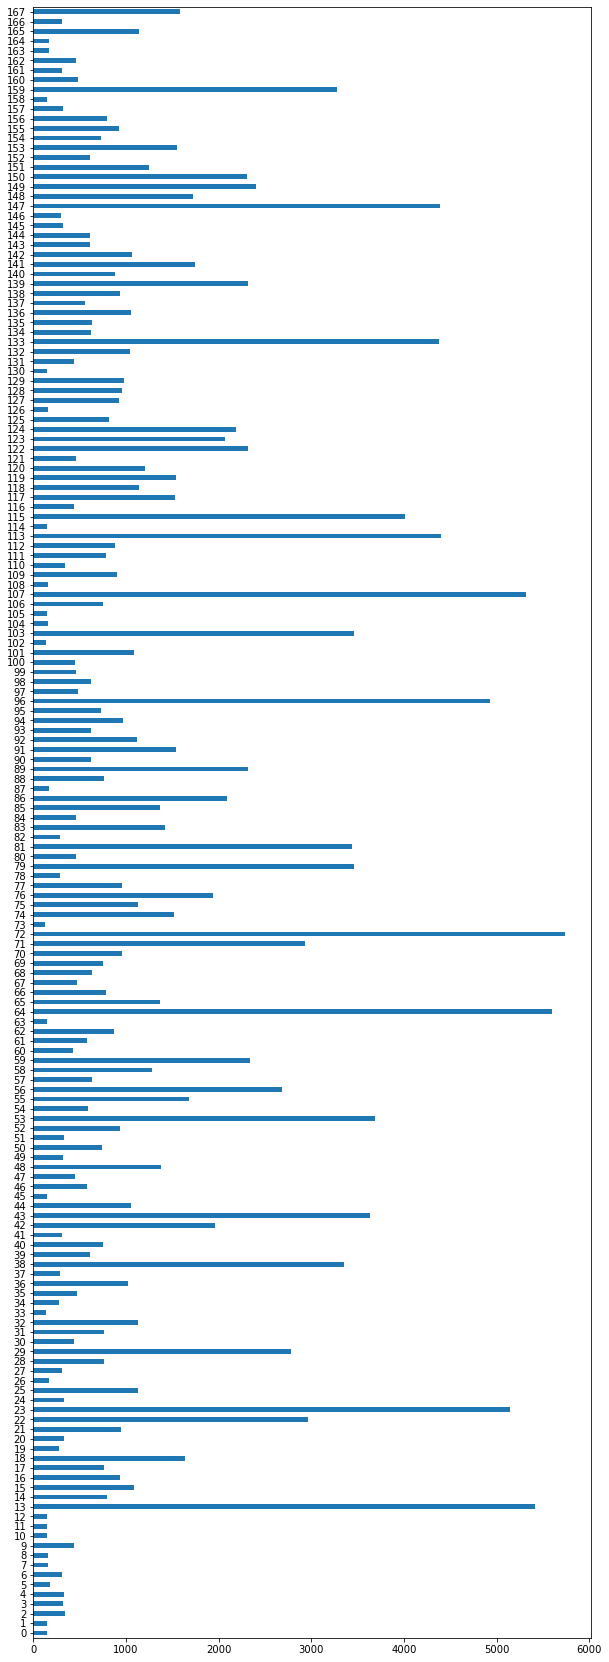

In [8]:
plt.figure(figsize=(10,30))
df_index['grapheme_root'].value_counts().sort_index().plot.barh()  

<AxesSubplot:>

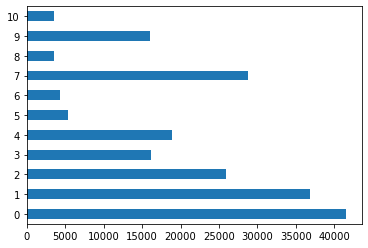

In [9]:
df_index['vowel_diacritic'].value_counts().sort_index().plot.barh()  

<AxesSubplot:>

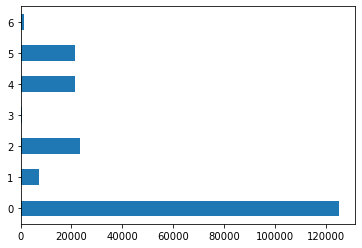

In [10]:
df_index['consonant_diacritic'].value_counts().sort_index().plot.barh()  

In [11]:
df_index['image_id']=df_index['image_id']+'.jpg'

In [12]:
df_index

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0.jpg,15,9,5,ক্ট্রো
1,Train_1.jpg,159,0,0,হ
2,Train_2.jpg,22,3,5,খ্রী
3,Train_3.jpg,53,2,2,র্টি
4,Train_4.jpg,71,9,5,থ্রো
...,...,...,...,...,...
200835,Train_200835.jpg,22,7,2,র্খে
200836,Train_200836.jpg,65,9,0,ত্তো
200837,Train_200837.jpg,2,1,4,অ্যা
200838,Train_200838.jpg,152,9,0,স্নো


In [13]:
df_index['consonant_diacritic'].value_counts() 
#7 values , # 7 columns one hot coding, output = 7 colums and softmax

0    125278
2     23465
5     21397
4     21270
1      7424
6      1387
3       619
Name: consonant_diacritic, dtype: int64

In [14]:
df_index.dtypes

image_id               object
grapheme_root           int64
vowel_diacritic         int64
consonant_diacritic     int64
grapheme               object
dtype: object

In [15]:
!pwd

/home/beth/Galvanize/capstone/capstone_2/src


In [16]:
df_index_1 = df_index.iloc[:44597,:]

In [17]:
df_index_1

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0.jpg,15,9,5,ক্ট্রো
1,Train_1.jpg,159,0,0,হ
2,Train_2.jpg,22,3,5,খ্রী
3,Train_3.jpg,53,2,2,র্টি
4,Train_4.jpg,71,9,5,থ্রো
...,...,...,...,...,...
44592,Train_44592.jpg,78,1,0,দ্মা
44593,Train_44593.jpg,86,2,0,ন্তি
44594,Train_44594.jpg,140,0,0,ষ্ক
44595,Train_44595.jpg,18,9,0,ক্ষো


<AxesSubplot:>

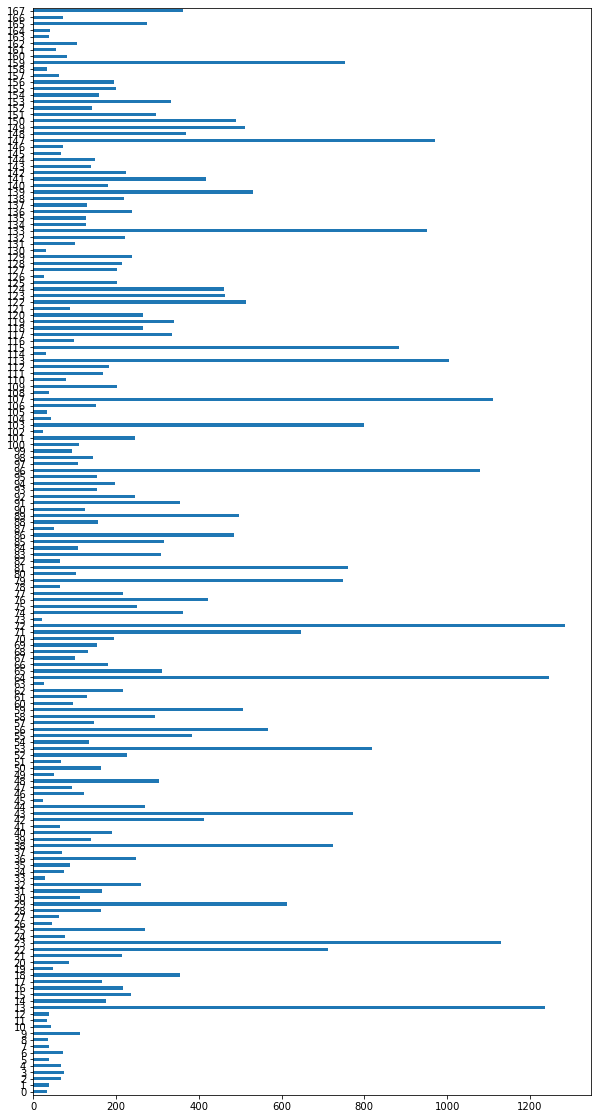

In [18]:
plt.figure(figsize=(10,20))
df_index_1['grapheme_root'].value_counts().sort_index().plot.barh()  

<AxesSubplot:>

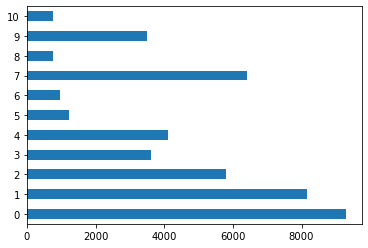

In [19]:
df_index_1['vowel_diacritic'].value_counts().sort_index().plot.barh()  

<AxesSubplot:>

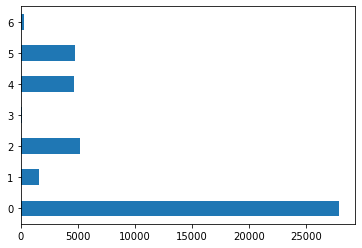

In [20]:
df_index_1['consonant_diacritic'].value_counts().sort_index().plot.barh()  

In [21]:
print(len(df_index_1['grapheme_root'].value_counts()))
df_index_1['grapheme_root'].value_counts()

168


72     1284
64     1247
13     1236
23     1129
107    1110
       ... 
63       27
126      26
45       24
102      24
73       22
Name: grapheme_root, Length: 168, dtype: int64

In [22]:
print(len(df_index_1['vowel_diacritic'].value_counts()))
df_index_1['vowel_diacritic'].value_counts()

11


0     9290
1     8159
7     6414
2     5813
4     4109
3     3613
9     3494
5     1220
6      951
8      769
10     765
Name: vowel_diacritic, dtype: int64

In [23]:
print(len(df_index_1['consonant_diacritic'].value_counts()))
df_index_1['consonant_diacritic'].value_counts() 

7


0    27933
2     5168
5     4784
4     4639
1     1641
6      293
3      139
Name: consonant_diacritic, dtype: int64

In [24]:
!ls


3_29_2021_dry_run_1.ipynb   3_31_2021_dry_run_with_layer_learning_rate.ipynb
3_29_2021_dry_run.ipynb     logs
3_30_2021_dry_run.ipynb     train.csv
3_31_2021_dry_run-lr.ipynb


In [25]:
df_shuffle = df_index_1.sample(frac=1) #shuffle

In [26]:
train = df_shuffle.iloc[:int(0.8*len(df_index_1)),:]
test = df_shuffle.iloc[int(0.8*len(df_index_1)):,:]

In [27]:
train.iloc[30415,:][3]

0

In [28]:
train.sample()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
29474,Train_29474.jpg,144,1,5,ষ্প্রা


In [32]:
from PIL import Image 

def mygenerator(dataframe): # X = image, y = target
    while True:
        sample = dataframe.sample()
        TRAIN_DIR = '/home/beth/Galvanize/capstone/capstone_2/data/train/'
        image_name = TRAIN_DIR + sample['image_id'].values[0]
        image=Image.open(image_name)
        y=np.zeros(7)
        y[sample["consonant_diacritic"].values[0]]=1   
        X = np.array(image).astype(np.int32)
        y = y.astype(np.int32).reshape(1,7) 
#         X = np.array([X,X,X]).reshape(1,137,236,3)
        X = X.reshape(1,137,236,1)
        yield X,y
# infinite numbers of X and y    

In [33]:
X,y = next(mygenerator(train)) # randomly pick a row 

In [34]:
X.shape

(1, 137, 236, 1)

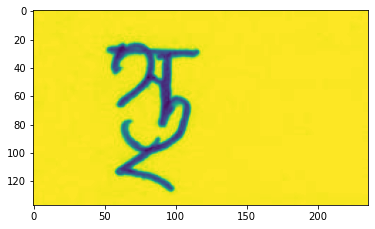

In [35]:
plt.imshow(X[0,:,:,0])

In [36]:
y

array([[1, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [37]:
# wanna try ResNet and AlexNet 3-31-2021

In [68]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, 7, activation="relu", padding="valid", input_shape=(137,236,1)),#input shape: [rows, columns, channels]
    keras.layers.Conv2D(32, 3, activation="relu", padding="valid"), # <--------------------------
    keras.layers.MaxPooling2D(2),

    keras.layers.Conv2D(64, 3, activation="relu", padding="valid"),
    keras.layers.Conv2D(64, 3, activation="relu", padding="valid"), #<--------------------------
    keras.layers.Conv2D(64, 3, activation="relu", padding="valid"), #<--------------------------
    keras.layers.MaxPooling2D(2),

    keras.layers.Conv2D(128, 3, activation="relu", padding="valid"),    
    keras.layers.Conv2D(128, 3, activation="relu", padding="valid"),
    keras.layers.Conv2D(128, 3, activation="relu", padding="valid"), # <--------------------------
    keras.layers.MaxPooling2D(2),
    
    keras.layers.Conv2D(128, 3, activation="relu", padding="valid"),
    keras.layers.Conv2D(128, 3, activation="relu", padding="valid"), # <--------------------------
    keras.layers.MaxPooling2D(2),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.3),     
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.3),      
    keras.layers.Dense(7, activation="softmax")
])

model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy',keras.metrics.Recall()])

# Details/Retrospectives:
# - add more layers <--------------------------
# - did not Norm layers (not common anymore)
# - no data augmentation
# - dropout 0.3  
# - batch size 32 
# - no SGD Momentum 
# - Learning rate added <--------------------------
# - no L2 weight decay 5
# - no 7 CNN ensemble: 


In [69]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_128 (Conv2D)          (None, 131, 230, 32)      1600      
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 129, 228, 32)      9248      
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 64, 114, 32)       0         
_________________________________________________________________
conv2d_130 (Conv2D)          (None, 62, 112, 64)       18496     
_________________________________________________________________
conv2d_131 (Conv2D)          (None, 60, 110, 64)       36928     
_________________________________________________________________
conv2d_132 (Conv2D)          (None, 58, 108, 64)       36928     
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 29, 54, 64)      

In [54]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=100),
    keras.callbacks.TensorBoard(log_dir='./logs')]
#keras.callbacks.ModelCheckpoint(filepath='./checkpoint/model.{epoch:02d}-{val_loss:.2f}.h5')

history = model.fit(mygenerator(train),
                    epochs=300,
                    steps_per_epoch=64, #<------------
                    validation_data=mygenerator(test),
                    validation_steps=30, 
                    callbacks=my_callbacks)                 


Epoch 1/300
64/64 [==============================] - 5s 70ms/step - loss: 2.4550 - accuracy: 0.2191 - recall_6: 0.1793 - val_loss: 1.2407 - val_accuracy: 0.6000 - val_recall_6: 0.6000
Epoch 2/300
64/64 [==============================] - 4s 67ms/step - loss: 1.5529 - accuracy: 0.4303 - recall_6: 0.3002 - val_loss: 1.4411 - val_accuracy: 0.5667 - val_recall_6: 0.0333
Epoch 3/300
64/64 [==============================] - 4s 65ms/step - loss: 1.4358 - accuracy: 0.5579 - recall_6: 0.1706 - val_loss: 1.2956 - val_accuracy: 0.6000 - val_recall_6: 0.3000
Epoch 4/300
64/64 [==============================] - 5s 83ms/step - loss: 1.3781 - accuracy: 0.5820 - recall_6: 0.3320 - val_loss: 1.0371 - val_accuracy: 0.7333 - val_recall_6: 0.4667
Epoch 5/300
64/64 [==============================] - 6s 89ms/step - loss: 1.2063 - accuracy: 0.6756 - recall_6: 0.3879 - val_loss: 1.3357 - val_accuracy: 0.6000 - val_recall_6: 0.4000
Epoch 6/300
64/64 [==============================] - 6s 88ms/step - loss: 1.3256

64/64 [==============================] - 5s 81ms/step - loss: 1.1398 - accuracy: 0.7084 - recall_6: 0.6015 - val_loss: 1.1208 - val_accuracy: 0.6333 - val_recall_6: 0.6000
Epoch 90/300
64/64 [==============================] - 5s 83ms/step - loss: 1.1309 - accuracy: 0.6689 - recall_6: 0.4871 - val_loss: 1.1815 - val_accuracy: 0.6333 - val_recall_6: 0.6333
Epoch 91/300
64/64 [==============================] - 5s 82ms/step - loss: 1.0732 - accuracy: 0.7283 - recall_6: 0.5675 - val_loss: 1.1560 - val_accuracy: 0.6333 - val_recall_6: 0.6333
Epoch 92/300
64/64 [==============================] - 5s 81ms/step - loss: 0.9429 - accuracy: 0.7698 - recall_6: 0.6977 - val_loss: 1.2194 - val_accuracy: 0.6000 - val_recall_6: 0.6000
Epoch 93/300
64/64 [==============================] - 5s 82ms/step - loss: 1.4342 - accuracy: 0.4990 - recall_6: 0.3496 - val_loss: 0.9515 - val_accuracy: 0.8333 - val_recall_6: 0.1000
Epoch 94/300
64/64 [==============================] - 5s 81ms/step - loss: 1.1498 - accu

In [55]:
score = model.evaluate(mygenerator(test), steps=200,verbose=0)

print('Test score:', score[0])
print('Test accuracy:', score[1])  # this is the one we care about

Test score: 1.1598566770553589
Test accuracy: 0.6349999904632568


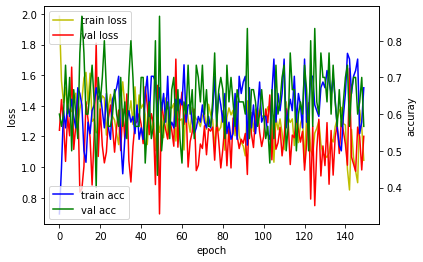

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()


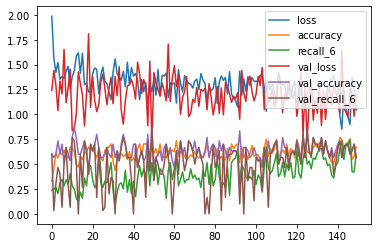

In [57]:
[plt.plot(history.history[i], label=i) for i in history.history.keys()]
plt.legend();

In [148]:
# confusion matrix
# from sklearn.metrics import confusion_matrix

# y_pred = model.predict(mygenerator(test),steps=200) # probability
# y_pred = np.argmax(y_pred, axis=1) # index of highest prob 
# y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

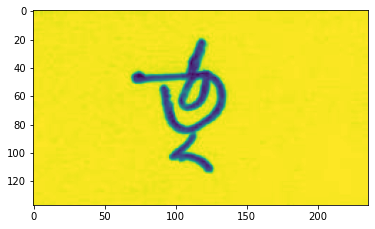

In [58]:
x,y= next(mygenerator(test))
x.shape
y.shape
plt.imshow(x[0,:,:,0])

In [59]:
prediction = [] 
actual = []
for x,y in mygenerator(test):
#     plt.imshow(x[0,:,:,0])
    actual.append(y.argmax())
    prediction.append(model.predict(x).argmax())
    if len(actual)>2000:
        break     

In [60]:
# actual

In [61]:
# prediction

In [62]:
# confusion matrix
from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
multiclass=confusion_matrix(actual, prediction)
print(multiclass)

Confusion Matrix
[[1269    0    0    0    0    0    0]
 [  67    0    0    0    0    0    0]
 [ 243    0    0    0    0    0    0]
 [   4    0    0    0    0    0    0]
 [ 198    0    0    0    0    0    0]
 [ 207    0    0    0    0    0    0]
 [  13    0    0    0    0    0    0]]


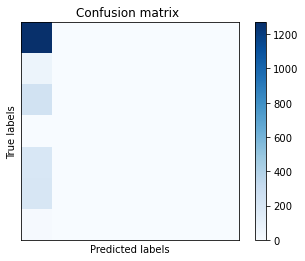

In [63]:
cm = confusion_matrix(actual, prediction)

plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()
